In [117]:
from time import time
import torch as th
import torch
from torch.autograd.functional import hessian
import tracemalloc
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
phi = 0.5 * (3.0 - 5 ** (0.5))


def dichotomy(f, l, r, eps, iterations, verbose=False):
    if r - l < eps:
        return (l + r) / 2.0, iterations
    mid = (l + r) / 2
    x1 = mid - eps / 3
    x2 = mid + eps / 3
    y1 = f(x1)
    y2 = f(x2)
    iterations += 1
    if y1 < y2:
        if verbose: print("dich shorter: ", (x1 - l) / (r - l))
        return dichotomy(f, l, x1, eps, iterations)
    else:
        if verbose: print("dich shorter: ", (r - x2) / (r - l))
        return dichotomy(f, x2, r, eps, iterations)

    
def golden(f, l, r, pred, is_first, eps, iterations=0, verbose=False):
    if abs(r - l) < eps:
        return (l + r) / 2.0, iterations
    len = r - l
    if is_first:
        x1 = l + len * phi
        y1 = f(x1)
        iterations += 1
        if (pred != []):
            x2 = pred[0]
            y2 = pred[1]
        else:
            x2 = r - len * phi
            y2 = f(x2)
            iterations += 1
    else:
        x2 = r - len * phi
        y2 = f(x2)
        iterations += 1
        if (pred != []):
            x1 = pred[0]
            y1 = pred[1]
        else:
            x1 = l + len * phi
            y1 = f(x1)
            iterations += 1
    if (y1 < y2):
        if verbose: print("golden shorter:", (x2 - l) / (r - l))
        return golden(f, l, x2, [x1, y1], 1, eps, iterations)
    else:
        if verbose: print("golden shorter:", (r - x1) / (r - l))
        return golden(f, x1, r, [x2, y2], 0, eps, iterations)


def fib(f, l, r, eps, verbose=False):
    fibbonaci_num = [1, 1]
    length = r - l
    while (fibbonaci_num[-1] < length / eps):
        fibbonaci_num.append(fibbonaci_num[-1] + fibbonaci_num[-2])
    n = len(fibbonaci_num) - 2
    x1 = l + fibbonaci_num[n - 1] * length / fibbonaci_num[n + 1]
    x2 = l + fibbonaci_num[n] * length / fibbonaci_num[n + 1]
    cnt = 2
    y1 = f(x1)
    y2 = f(x2)
    for i in range(1, n):
        pred_l = l
        pred_r = r
        if (y1 < y2):
            y2 = y1
            r = x2
            x2 = x1
            x1 = l + fibbonaci_num[n - i] / fibbonaci_num[n + 2 - i] * (r - l)
            y1 = f(x1)
        else:
            y1 = y2
            l = x1
            x1 = x2
            x2 = l + fibbonaci_num[n + 1 - i] / fibbonaci_num[n + 2 - i] * (r - l)
            y2 = f(x2)
        if verbose: print("fib shorter:", (r - l) / (pred_r - pred_l))
        cnt += 1 
    return (l + r) / 2.0, cnt

In [3]:
class ConstOptimizer:
    def __init__(self, x):
        self.x = x
        
    def __call__(self):
        return self.x
    

class DivisionOptimizer:
    def __init__(self, x, mx):
        self.x = x
        self.mx = mx
        
    def __call__(self):
        self.x /= 2
        self.x = max(self.x, self.mx)
        return self.x * 2
    
    
class GoldenOptimizer:
    def __init__(self, l, r):
        self.l = l
        self.r = r
        
    def __call__(self, f):
        return golden(f, self.l, self.r, [], True, 1e-9)[0]

In [208]:
COLOR_RED = np.linspace(240, 166, 256) / 255.
COLOR_GREEN = np.linspace(244, 188, 256) / 255.
COLOR_BLUE = np.linspace(246, 203, 256) / 255.

def plot_levels(func, xrange, yrange, levels):
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = float(func(th.Tensor([X[i, j], Y[i, j]]).double()))

    colors = np.vstack([COLOR_RED, COLOR_GREEN, COLOR_BLUE]).T
    my_cmap = ListedColormap(colors)

    _ = plt.contourf(X, Y, Z, levels=levels, cmap=my_cmap)
    CS = plt.contour(X, Y, Z, levels=levels, colors='#ABBECC')
    plt.clabel(CS, inline=1, fontsize=8, colors='#AAAEBB')
    plt.grid()
    
    
def plot_trace(trace, clr=None, label=None):
    x_values, y_values = zip(*trace)
    if clr is None:
        clr = 'C2'
    if label is None:
        label = 'Trajectory'
    plt.plot(x_values, y_values, '-o', linewidth=1.0, ms=5.0,
             alpha=1.0, c=clr, label=label)

In [146]:
def maybe_break_optimization(f, x, dx, xold, iters, eps_grad=1e-6, eps=1e-10, max_iters=1000):
    if iters >= max_iters:
        return True, 'Exceed limit of iterations'
    if xold is not None and torch.norm(x - xold) < eps:
        return True, 'Exceed limit of accuracy for argument'
    if xold is not None and abs(f(x) - f(xold)) < eps:
        return True, 'Exceed limit of accuracy for function'
    if torch.dot(x, x) > 1e10:
        return True, 'Divergence'
    if torch.max(torch.abs(dx)) < eps_grad:
        return True, 'Reached muninum or plateau'
    return False, ''

In [147]:
class Tracer:
    def start(self):
        self.memory = 0
        self.start_time = time()
        tracemalloc.start()
    
    def stop(self):
        self.elapsed_time = time() - self.start_time
        res = tracemalloc.take_snapshot()
        stats = res.statistics(cumulative=True, key_type='filename')
        for stat in stats:
            self.memory += stat.size
        tracemalloc.stop()
    
    def print(self):
        print(f'Elapsed time: {math.ceil(self.elapsed_time * 1000)} ms')
        print(f'Memory used: {self.memory // 2**10} Kb')        


In [148]:
def gradient_descent(f, optimizer, x0, tracer):
    print(f'----- Gradient descent with optimizer {optimizer.__class__.__name__} -----')
    x = x0.requires_grad_()
    
    iters = 0
    trace = [x0.detach().numpy()]

    tracer.start()
    while True:
        if x.grad is not None:
            x.grad.data.zero_()
        y = f(x)
        y.backward()
        
        xold = torch.tensor(trace[-2]) if len(trace) > 1 else None
        stop, reason = maybe_break_optimization(f, x, x.grad, xold, iters)
        if stop:
            print(reason)
            break
        
        def g(lmbd):
            return f(x.data - lmbd * x.grad.data)
        step = optimizer(g)
        
        x.data = x.data - step * x.grad.data
        trace += [x.detach().numpy()]
        iters += 1

    tracer.stop()
    print(f'Num iters: {iters}')
    print(f'Optimized value: {f(x)}')
    return np.array(trace), iters

In [201]:
def gradient(f, val):
    val.requires_grad_()
    val.retain_grad()
    if val.grad is not None:
        val.grad.data.zero_()
    y = f(val)
    y.backward()
    return val.grad.data.clone().detach()


def conjugate_gradients(f, linear_optimizer, x0, tracer):
    print(f'----- Conjugate gradients with optimizer {linear_optimizer.__class__.__name__} -----')
    x = x0.requires_grad_()
    
    iters = 0
    trace = [x0.detach().numpy()]
    grad = gradient(f, x)
    
    tracer.start()
    while True:
        xold = torch.tensor(trace[-2]) if len(trace) > 1 else None
        stop, reason = maybe_break_optimization(f, x, grad, xold, iters)
        if stop:
            print(reason)
            break

        def g(lmbd):
            return f(x - lmbd * grad)
        step = linear_optimizer(g)
        
        next_x = x - step * grad  # optimization step
        next_grad = gradient(f, next_x)
        grad_offset = 0.0
        if iters % (len(x)*len(x)) != 0:
            grad_offset = torch.dot(next_grad, next_grad) / torch.dot(grad, grad) 
        
        grad = next_grad - grad_offset * grad  # direction shift
        x = next_x
        trace += [x.detach().numpy()]
        iters += 1
    
    tracer.stop()
    print(f'Num iters: {iters}')
    print(f'Optimized value: {f(x)}')
    return np.array(trace), iters

In [202]:
def positive(hess):
    eig = np.linalg.eigvals(hess)
    if all(eig > 0):
        return hess
    else:
        return hess + (1 + 1e-6 - min(eig)) * np.eye(hess.shape[0])


def newton(f, linear_optimizer, x0, tracer):
    print(f'----- Newton method with optimizer {linear_optimizer.__class__.__name__} -----')
    x = x0.requires_grad_()
    
    iters = 0
    trace = [x0.detach().numpy()]
    grad = gradient(f, x)
    
    tracer.start()
    while True:
        xold = torch.tensor(trace[-2]) if len(trace) > 1 else None
        stop, reason = maybe_break_optimization(f, x, grad, xold, iters)
        if stop:
            print(reason)
            break
        
        hesse = positive(hessian(f, x).numpy())
        inv_hesse = np.linalg.inv(hesse)
        direction = torch.tensor(inv_hesse.dot(grad.numpy()))
        
        def g(lmbd):
            return f(x - lmbd * direction)
        step = linear_optimizer(g)

        x = x - step * direction
        trace += [x.detach().numpy()]
        grad = gradient(f, x)
        iters += 1
    
    tracer.stop()
    print(f'Num iters: {iters}')
    print(f'Optimized value: {f(x)}')
    return np.array(trace), iters

In [203]:
def plot(f, xs, levels):
    plot_levels(f, [xs[:, 0].min() - 0.3, xs[:, 0].max() + 0.3], 
                [xs[:, 1].min() - 0.3, xs[:, 1].max() + 0.3], levels)
    plot_trace(xs)
    plt.show()
    
    
def plot3(f, xs1, xs2, xs3, levels):
    plot_levels(f, [xs1[:, 0].min() - 0.3, xs1[:, 0].max() + 0.3], 
                [xs1[:, 1].min() - 0.3, xs1[:, 1].max() + 0.3], levels)
    plot_trace(xs1, clr='r', label='drad_desc')
    plot_trace(xs2, clr='g', label='conj_grad')
    plot_trace(xs3, clr='m', label='newton')
    plt.show()

In [204]:
PLOT_LEVELS = [0, 0.25, 1, 4, 9, 16, 25]

def run_all(func, levels=PLOT_LEVELS):
    np.random.seed(123123)
    torch.random.manual_seed(1337)  

    dims=2
    tracer = Tracer()
    optimizer = GoldenOptimizer(0, 1.01)
    point = torch.tensor(np.random.rand(dims)).requires_grad_()

    trace, _ = gradient_descent(func, optimizer, point.clone().detach(), tracer)
    tracer.print()
    plot(func, trace, levels=levels)

    trace, _ = conjugate_gradients(func, optimizer, point.clone().detach(), tracer)
    tracer.print()
    plot(func, trace, levels=levels)

    trace, _ = newton(func, optimizer, point.clone().detach(), tracer)
    tracer.print()
    plot(func, trace, levels=levels)


def run_all3(func, levels=PLOT_LEVELS):
    np.random.seed(123123)
    torch.random.manual_seed(1337)  

    dims=2
    tracer = Tracer()
    optimizer = GoldenOptimizer(0, 1.01)
    point = torch.tensor(np.random.rand(dims)).requires_grad_()

    trace1, _ = gradient_descent(func, optimizer, point.clone().detach(), tracer)
    tracer.print()

    trace2, _ = conjugate_gradients(func, optimizer, point.clone().detach(), tracer)
    tracer.print()

    trace3, _ = newton(func, optimizer, point.clone().detach(), tracer)
    tracer.print()
    plot3(func, trace1, trace2, trace3, levels=levels)

----- Gradient descent with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 6
Optimized value: 1.241677521105743e-14
Elapsed time: 32 ms
Memory used: 29 Kb
----- Conjugate gradients with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 8
Optimized value: 1.8976072479247494e-09
Elapsed time: 38 ms
Memory used: 8 Kb
----- Newton method with optimizer GoldenOptimizer -----
Reached muninum or plateau
Num iters: 1
Optimized value: 2.8409561093700506e-19
Elapsed time: 6 ms
Memory used: 4 Kb


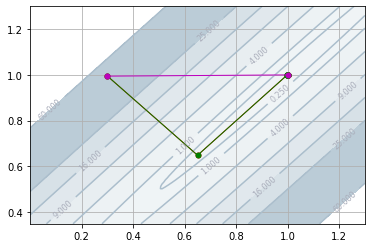

In [205]:
def g1(x):
    return 100 * (x[1] - x[0]) ** 2 + (1 - x[0]) ** 2

run_all3(g1, levels=[0, 0.25, 1, 4, 9, 16, 25, 60])

----- Gradient descent with optimizer GoldenOptimizer -----
Exceed limit of iterations
Num iters: 1000
Optimized value: 0.0029594089220038736
Elapsed time: 4344 ms
Memory used: 178 Kb


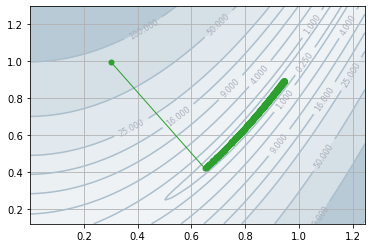

----- Conjugate gradients with optimizer GoldenOptimizer -----
Exceed limit of iterations
Num iters: 1000
Optimized value: 12692.335058666293
Elapsed time: 6420 ms
Memory used: 846 Kb


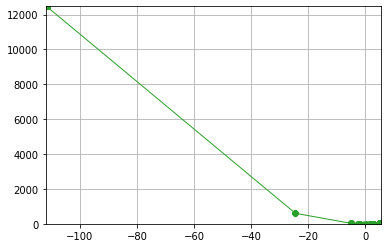

----- Newton method with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 6
Optimized value: 1.2278021580096909e-21
Elapsed time: 47 ms
Memory used: 10 Kb


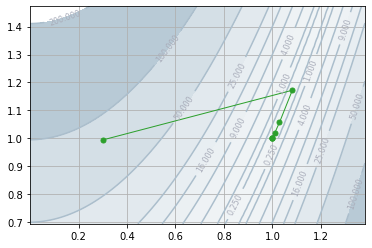

In [207]:
def g2(x):
    return 100 * (x[1] - x[0]**2) ** 2 + (1 - x[0]) ** 2

run_all(g2, levels=[0, 0.25, 1, 4, 9, 16, 25, 50, 100, 200])

In [196]:
def run_five(func, levels=PLOT_LEVELS):
    np.random.seed(123123)
    torch.random.manual_seed(1337)  

    dims=2
    tracer = Tracer()
    optimizer = GoldenOptimizer(0, 1.01)
    
    for i in range(5):
        print(f'########################## RUN {i+1} ##########################')
        point = torch.tensor(np.random.rand(dims) * 5).requires_grad_()

        trace1, _ = gradient_descent(func, optimizer, point.clone().detach(), tracer)
        tracer.print()

        trace2, _ = conjugate_gradients(func, optimizer, point.clone().detach(), tracer)
        tracer.print()

        trace3, _ = newton(func, optimizer, point.clone().detach(), tracer)
        tracer.print()
        plot3(func, trace1, trace2, trace3, levels=levels)

########################## RUN 1 ##########################
----- Gradient descent with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 12
Optimized value: -3.035063527559788
Elapsed time: 121 ms
Memory used: 8 Kb
----- Conjugate gradients with optimizer GoldenOptimizer -----
Exceed limit of accuracy for argument
Num iters: 9
Optimized value: -3.0350571660984613
Elapsed time: 91 ms
Memory used: 7 Kb
----- Newton method with optimizer GoldenOptimizer -----
Reached muninum or plateau
Num iters: 4
Optimized value: -3.0350635275635987
Elapsed time: 48 ms
Memory used: 8 Kb


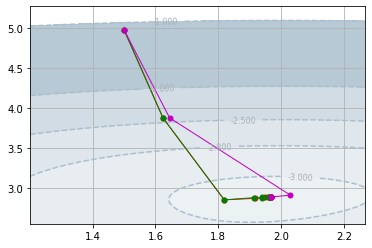

########################## RUN 2 ##########################
----- Gradient descent with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 11
Optimized value: -3.0350635275546636
Elapsed time: 117 ms
Memory used: 7 Kb
----- Conjugate gradients with optimizer GoldenOptimizer -----
Exceed limit of accuracy for argument
Num iters: 5
Optimized value: -3.034739067153688
Elapsed time: 56 ms
Memory used: 4 Kb
----- Newton method with optimizer GoldenOptimizer -----
Reached muninum or plateau
Num iters: 3
Optimized value: -3.0350635275635307
Elapsed time: 42 ms
Memory used: 6 Kb


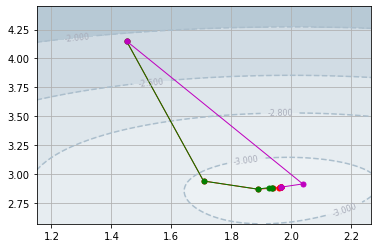

########################## RUN 3 ##########################
----- Gradient descent with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 13
Optimized value: -3.035063527561878
Elapsed time: 105 ms
Memory used: 6 Kb
----- Conjugate gradients with optimizer GoldenOptimizer -----
Exceed limit of accuracy for argument
Num iters: 13
Optimized value: -3.0350582464819573
Elapsed time: 140 ms
Memory used: 10 Kb
----- Newton method with optimizer GoldenOptimizer -----
Reached muninum or plateau
Num iters: 3
Optimized value: -3.035063527563519
Elapsed time: 42 ms
Memory used: 5 Kb


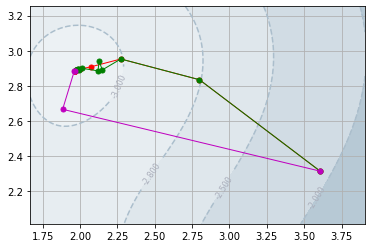

########################## RUN 4 ##########################
----- Gradient descent with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 10
Optimized value: -3.1693172162235173
Elapsed time: 88 ms
Memory used: 5 Kb
----- Conjugate gradients with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 12
Optimized value: -3.169317216221826
Elapsed time: 123 ms
Memory used: 9 Kb
----- Newton method with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 4
Optimized value: -3.1693172162250813
Elapsed time: 52 ms
Memory used: 7 Kb


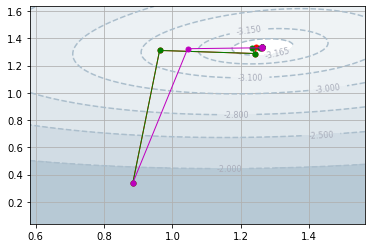

########################## RUN 5 ##########################
----- Gradient descent with optimizer GoldenOptimizer -----
Exceed limit of accuracy for function
Num iters: 14
Optimized value: -3.169317216218791
Elapsed time: 112 ms
Memory used: 6 Kb
----- Conjugate gradients with optimizer GoldenOptimizer -----
Exceed limit of accuracy for argument
Num iters: 3
Optimized value: -3.0689464886220152
Elapsed time: 31 ms
Memory used: 2 Kb
----- Newton method with optimizer GoldenOptimizer -----
Reached muninum or plateau
Num iters: 4
Optimized value: -3.1693172162250813
Elapsed time: 47 ms
Memory used: 6 Kb


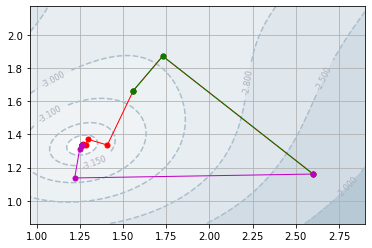

In [206]:
def h(x):
    return -(2 * torch.exp(-((x[0] - 1) / 2) ** 2 - (x[1] - 1) ** 2) +
             3 * torch.exp(-((x[0] - 2) / 3) ** 2 - ((x[1] - 3) / 2) ** 2))

run_five(h, levels=[-3.165, -3.15, -3.1, -3, -2.8, -2.5, -2, -1])